In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn.preprocessing import MultiLabelBinarizer
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from stargazer.stargazer import Stargazer
from statsmodels.stats.diagnostic import het_white
import scipy
from statsmodels.compat import lzip

pd.set_option('display.max_columns', 500)
plt.rcParams["figure.figsize"] = (30, 10)

In [2]:
data = pd.read_csv('df.csv', low_memory=False)
data

,aso,brand,capacity,color,condition,features,first_owner,fuel_type,horse_power,mileage,model,no_accidents,number_of_doors,origin_country,price,price_currency,transmission,type,url,version,year
0,Tak,Rolls-Royce,6 749 cm3,Czarny,Używane,"ABS,Elektryczne szyby przednie,Poduszka powiet...",Tak,Benzyna,599 KM,49 000 km,Cullinan,Tak,5,NaN,1616999,PLN,Automatyczna,NaN,https://www.otomoto.pl/oferta/rolls-royce-cull...,Black Badge,2020
1,NaN,Rolls-Royce,6 750 cm3,Niebieski,Używane,NaN,NaN,Benzyna,335 KM,48 000 km,Silver Spur,NaN,5,NaN,298800,PLN,Automatyczna,NaN,https://www.otomoto.pl/oferta/rolls-royce-silv...,NaN,1991
2,Tak,Rolls-Royce,6 592 cm3,Szary,Używane,"ABS,Elektryczne szyby przednie,Poduszka powiet...",NaN,Benzyna,632 KM,1 800 km,Wraith,Tak,2,Włochy,1950000,PLN,Automatyczna,NaN,https://www.otomoto.pl/oferta/rolls-royce-wrai...,NaN,2019
3,NaN,Rolls-Royce,5 379 cm3,Biały,Używane,"ABS,Immobilizer,Alufelgi,Gniazdo SD,Podgrzewan...",Tak,Benzyna,326 KM,86 400 km,Silver Seraph,NaN,4,NaN,197000,PLN,Automatyczna,NaN,https://www.otomoto.pl/oferta/rolls-royce-silv...,NaN,1999
4,NaN,Rolls-Royce,4 000 cm3,Czarny,Używane,NaN,Tak,Benzyna,130 KM,50 000 km,Wraith,NaN,4,Wielka Brytania,25000,PLN,Manualna,NaN,https://www.otomoto.pl/oferta/rolls-royce-wrai...,NaN,1952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://carsmile.pl/oferta/peugeot/208/hatchba...,NaN,NaN
104434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://carsmile.pl/oferta/nissan/qashqai/cros...,NaN,NaN
104435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://carsmile.pl/oferta/nissan/qashqai/cros...,NaN,NaN
104436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://carsmile.pl/oferta/audi/a6/kombi-leasi...,NaN,NaN


In [3]:
data['aso'].value_counts()

Tak    43759
aso       32
Name: aso, dtype: int64

In [4]:
data = data.dropna(subset=['features', 'capacity', 'horse_power', 'mileage'])
data

,aso,brand,capacity,color,condition,features,first_owner,fuel_type,horse_power,mileage,model,no_accidents,number_of_doors,origin_country,price,price_currency,transmission,type,url,version,year
0,Tak,Rolls-Royce,6 749 cm3,Czarny,Używane,"ABS,Elektryczne szyby przednie,Poduszka powiet...",Tak,Benzyna,599 KM,49 000 km,Cullinan,Tak,5,NaN,1616999,PLN,Automatyczna,NaN,https://www.otomoto.pl/oferta/rolls-royce-cull...,Black Badge,2020
2,Tak,Rolls-Royce,6 592 cm3,Szary,Używane,"ABS,Elektryczne szyby przednie,Poduszka powiet...",NaN,Benzyna,632 KM,1 800 km,Wraith,Tak,2,Włochy,1950000,PLN,Automatyczna,NaN,https://www.otomoto.pl/oferta/rolls-royce-wrai...,NaN,2019
3,NaN,Rolls-Royce,5 379 cm3,Biały,Używane,"ABS,Immobilizer,Alufelgi,Gniazdo SD,Podgrzewan...",Tak,Benzyna,326 KM,86 400 km,Silver Seraph,NaN,4,NaN,197000,PLN,Automatyczna,NaN,https://www.otomoto.pl/oferta/rolls-royce-silv...,NaN,1999
5,NaN,Rolls-Royce,6 750 cm3,Biały,Używane,"Elektryczne szyby przednie,Klimatyzacja manual...",NaN,Benzyna,200 KM,650 000 km,Silver Shadow,NaN,4,NaN,59900,PLN,Automatyczna,NaN,https://www.otomoto.pl/oferta/rolls-royce-silv...,NaN,1975
6,Tak,Rolls-Royce,5 379 cm3,Zielony,Używane,"ABS,Elektryczne szyby przednie,Poduszka powiet...",NaN,Benzyna,326 KM,58 650 km,Silver Seraph,NaN,4,Kanada,189900,PLN,Automatyczna,NaN,https://www.otomoto.pl/oferta/rolls-royce-silv...,NaN,1999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104397,NaN,BMW,1 995 cm3,Czarny,Używane,"ABS,Elektrycznie ustawiane lusterka,Poduszka p...",NaN,Diesel,190 KM,6 000 km,Seria 4,NaN,5,NaN,261900,PLN,Automatyczna,NaN,https://www.otomoto.pl/oferta/bmw-seria-4-420d...,420d Gran Coupe xDrive,2021
104398,NaN,BMW,1 995 cm3,Srebrny,Używane,"ABS,Elektryczne szyby przednie,Poduszka powiet...",NaN,Benzyna,150 KM,203 000 km,Seria 3,NaN,4,NaN,21800,PLN,Manualna,NaN,https://www.otomoto.pl/oferta/bmw-seria-3-2-0-...,320i,2007
104399,Tak,BMW,1 997 cm3,Niebieski,Używane,"ABS,Elektryczne szyby przednie,Poduszka powiet...",Tak,Benzyna,183 KM,145 000 km,Seria 4,Tak,2,Polska,65190,PLN,Manualna,NaN,https://www.otomoto.pl/oferta/bmw-seria-4-bmw-...,NaN,2014
104400,Tak,BMW,2 998 cm3,Czarny,Używane,"ABS,Elektrycznie ustawiane lusterka,Poduszka p...",Tak,Benzyna,340 KM,36 000 km,Seria 8,Tak,4,NaN,399750,PLN,Automatyczna,NaN,https://www.otomoto.pl/oferta/bmw-seria-8-bmw-...,840i,2020


# Co do zrobienia z danymi? 
- aso na 0-1 X 
- OH brand X
- capacity na int X
- OH color X
- condition 0-1 X
- OH features X 
- first_owner bool X 
- fuel_type OH X 
- horse_power na int X 
- mileage  git na int X
- no_accidents X
- number_of_doors X 
- origin country OH 
- price - Y 
- transmission - if automatic 
- year 

In [5]:
def map_aso(row): 
    if row == 'Tak': 
        return 1 
    else: 
        return 0 

def map_capacity(row): 
    split_list = row.split(' ')
    try:  
        if len(split_list) == 2:
            return int(''.join(split_list[:1]))
        else: 
            return int(''.join(split_list[:2]))
            
    except ValueError: 
        return row
        
def map_condition(row): 
    if row == 'Używane':
        return 0
    else: 
        return 1 

def map_transmission(row): 
    if row == 'Automatyczna': 
        return 1 
    else :
        return 0 

In [6]:
data = data.dropna(subset=['features', 'capacity', 'horse_power', 'mileage'])

data['features'] = data['features'].apply(lambda x: x.split(','))

lb = MultiLabelBinarizer()
features = lb.fit_transform(data['features'])
features_df = pd.DataFrame(features, columns=lb.classes_)

df = data.loc[data['fuel_type'].isin(['Benzyna', 'Diesel', 'Hybryda', 'Benzyna+LPG', 'Elektryczny'])]

print(data.shape)
df = pd.concat([df.drop(columns='brand'), pd.get_dummies(df['brand'], drop_first=True)], axis=1)
df = pd.concat([df.drop(columns='fuel_type'), pd.get_dummies(df['fuel_type'], drop_first=True)], axis=1)


df['aso'] = df['aso'].dropna().apply(map_aso)
df['capacity'] = df['capacity'].dropna().apply(map_capacity)
df['horse_power'] = df['horse_power'].dropna().apply(map_capacity)
df['mileage'] = df['mileage'].dropna().apply(map_capacity)
df['no_accidents'] = df['no_accidents'].apply(map_aso)
df['first_owner'] = df['first_owner'].apply(map_aso)
df['condition'] = df['condition'].apply(map_condition)

df['transmission'] = df['transmission'].apply(map_transmission)
df = (df.rename(columns={'transmission': 'automatyczna', 'condition': 'new'})
        .fillna(0)
        .drop(columns=['origin_country', 'model', 'type', 'url', 'version', 'price_currency', 'color', 'features'])
        .dropna()
        .astype(int)
        .reset_index(drop=True))

print(df.shape)


(80208, 21)
(80165, 41)


In [7]:
cars = pd.get_dummies(data['brand']).drop(columns='brand').columns.tolist()
print(', '.join(cars))

Alfa Romeo, Audi, BMW, Bentley, Chevrolet, Citroën, Dacia, Ferrari, Fiat, Kia, Lamborghini, Land Rover, Lexus, MINI, Maserati, Mazda, McLaren, Mercedes-Benz, Mitsubishi, Porsche, Renault, Rolls-Royce, Saab, Seat, Suzuki, Toyota, Volvo, Škoda


In [8]:
features_cols = features_df.columns.tolist()
print(len(features_cols))
print(', '.join(features_cols))

71
ABS, ASR (kontrola trakcji), Alarm, Alufelgi, Asystent parkowania, Asystent pasa ruchu, Bluetooth, CD, Centralny zamek, Czujnik deszczu, Czujnik martwego pola, Czujnik zmierzchu, Czujniki parkowania przednie, Czujniki parkowania tylne, Dach panoramiczny, ESP (stabilizacja toru jazdy), Elektrochromatyczne lusterka boczne, Elektrochromatyczne lusterko wsteczne, Elektryczne szyby przednie, Elektryczne szyby tylne, Elektrycznie ustawiane fotele, Elektrycznie ustawiane lusterka, Gniazdo AUX, Gniazdo SD, Gniazdo USB, HUD (wyświetlacz przezierny), Hak, Immobilizer, Isofix, Kamera cofania, Klimatyzacja automatyczna, Klimatyzacja czterostrefowa, Klimatyzacja dwustrefowa, Klimatyzacja manualna, Komputer pokładowy, Kurtyny powietrzne, MP3, Nawigacja GPS, Odtwarzacz DVD, Ogranicznik prędkości, Ogrzewanie postojowe, Podgrzewana przednia szyba, Podgrzewane lusterka boczne, Podgrzewane przednie siedzenia, Podgrzewane tylne siedzenia, Poduszka powietrzna chroniąca kolana, Poduszka powietrzna kierow

In [9]:
df

,aso,capacity,new,first_owner,horse_power,mileage,no_accidents,number_of_doors,price,automatyczna,year,Audi,BMW,Bentley,Chevrolet,Citroën,Dacia,Ferrari,Fiat,Kia,Lamborghini,Land Rover,Lexus,MINI,Maserati,Mazda,McLaren,Mercedes-Benz,Mitsubishi,Porsche,Renault,Rolls-Royce,Saab,Seat,Suzuki,Toyota,Volvo,Škoda,Benzyna+LPG,Diesel,Hybryda
0,1,6749,0,1,599,49000,1,5,1616999,1,2020,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1,6592,0,0,632,1800,1,2,1950000,1,2019,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,5379,0,1,326,86400,0,4,197000,1,1999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,6750,0,0,200,650000,0,4,59900,1,1975,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1,5379,0,0,326,58650,0,4,189900,1,1999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80160,0,1995,0,0,190,6000,0,5,261900,1,2021,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
80161,0,1995,0,0,150,203000,0,4,21800,0,2007,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
80162,1,1997,0,1,183,145000,1,2,65190,0,2014,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
80163,1,2998,0,1,340,36000,1,4,399750,1,2020,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
vif_data = pd.DataFrame()
vif_cols = df.drop(columns=cars[1:]).drop(columns=['price', 'number_of_doors', 'capacity']).columns
vif_version_df = df.loc[:, vif_cols]
vif_data["feature"] = vif_cols

vif_data["VIF"] = [variance_inflation_factor(vif_version_df.values, i)
                          for i in range(len(vif_cols))]


In [11]:
vif_data

,feature,VIF
0,aso,3.529963
1,new,2.357939
2,first_owner,2.363233
3,horse_power,6.572882
4,mileage,4.642534
5,no_accidents,3.616543
6,automatyczna,3.076949
7,year,12.499704
8,Benzyna+LPG,1.108573
9,Diesel,1.927110


In [12]:
df.drop(columns=cars[1:]).describe().T

,count,mean,std,min,25%,50%,75%,max
aso,80165.0,0.522036,0.499517,0.0,0.0,1.0,1.0,1.0
capacity,80165.0,1936.723807,774.353906,647.0,1498.0,1896.0,1998.0,7011.0
new,80165.0,0.125816,0.331643,0.0,0.0,0.0,0.0,1.0
first_owner,80165.0,0.372993,0.483603,0.0,0.0,0.0,1.0,1.0
horse_power,80165.0,165.771933,89.393867,1.0,110.0,143.0,190.0,1321.0
mileage,80165.0,122414.565833,93871.439095,1.0,38000.0,118140.0,189716.0,999999.0
no_accidents,80165.0,0.630599,0.482646,0.0,0.0,1.0,1.0,1.0
number_of_doors,80165.0,4.618512,0.799441,0.0,5.0,5.0,5.0,6.0
price,80165.0,94327.677640,130995.259228,690.0,23990.0,53900.0,115900.0,3500000.0
automatyczna,80165.0,0.451731,0.497668,0.0,0.0,0.0,1.0,1.0


In [13]:
df.loc[:, df.columns != 'price'].drop(columns=cars[1:]).corr() 

,aso,capacity,new,first_owner,horse_power,mileage,no_accidents,number_of_doors,automatyczna,year,Benzyna+LPG,Diesel,Hybryda
aso,1.000000,-0.039273,-0.367110,0.513223,-0.004226,-0.024231,0.254934,0.065847,0.009661,0.108462,-0.076140,0.041291,-0.015741
capacity,-0.039273,1.000000,-0.019230,-0.063047,0.832994,0.105371,-0.035211,-0.243028,0.461263,-0.142124,-0.026207,0.105786,0.028541
new,-0.367110,-0.019230,1.000000,-0.243603,0.131864,-0.494277,0.290361,0.036967,0.231869,0.454689,-0.027273,-0.113969,0.156291
first_owner,0.513223,-0.063047,-0.243603,1.000000,0.000742,-0.147024,0.205037,0.066754,0.056123,0.227053,-0.057154,0.026559,0.012360
horse_power,-0.004226,0.832994,0.131864,0.000742,1.000000,-0.157548,0.054841,-0.219550,0.552674,0.163970,-0.065503,-0.023149,0.022169
mileage,-0.024231,0.105371,-0.494277,-0.147024,-0.157548,1.000000,-0.212445,-0.010195,-0.275358,-0.735862,0.124641,0.287352,-0.177062
no_accidents,0.254934,-0.035211,0.290361,0.205037,0.054841,-0.212445,1.000000,0.060554,0.104653,0.230649,-0.050826,-0.016714,0.040958
number_of_doors,0.065847,-0.243028,0.036967,0.066754,-0.219550,-0.010195,0.060554,1.000000,-0.065724,0.174366,0.010736,0.115465,0.038289
automatyczna,0.009661,0.461263,0.231869,0.056123,0.552674,-0.275358,0.104653,-0.065724,1.000000,0.327302,-0.101898,0.063713,0.227657
year,0.108462,-0.142124,0.454689,0.227053,0.163970,-0.735862,0.230649,0.174366,0.327302,1.000000,-0.119292,-0.012099,0.181663


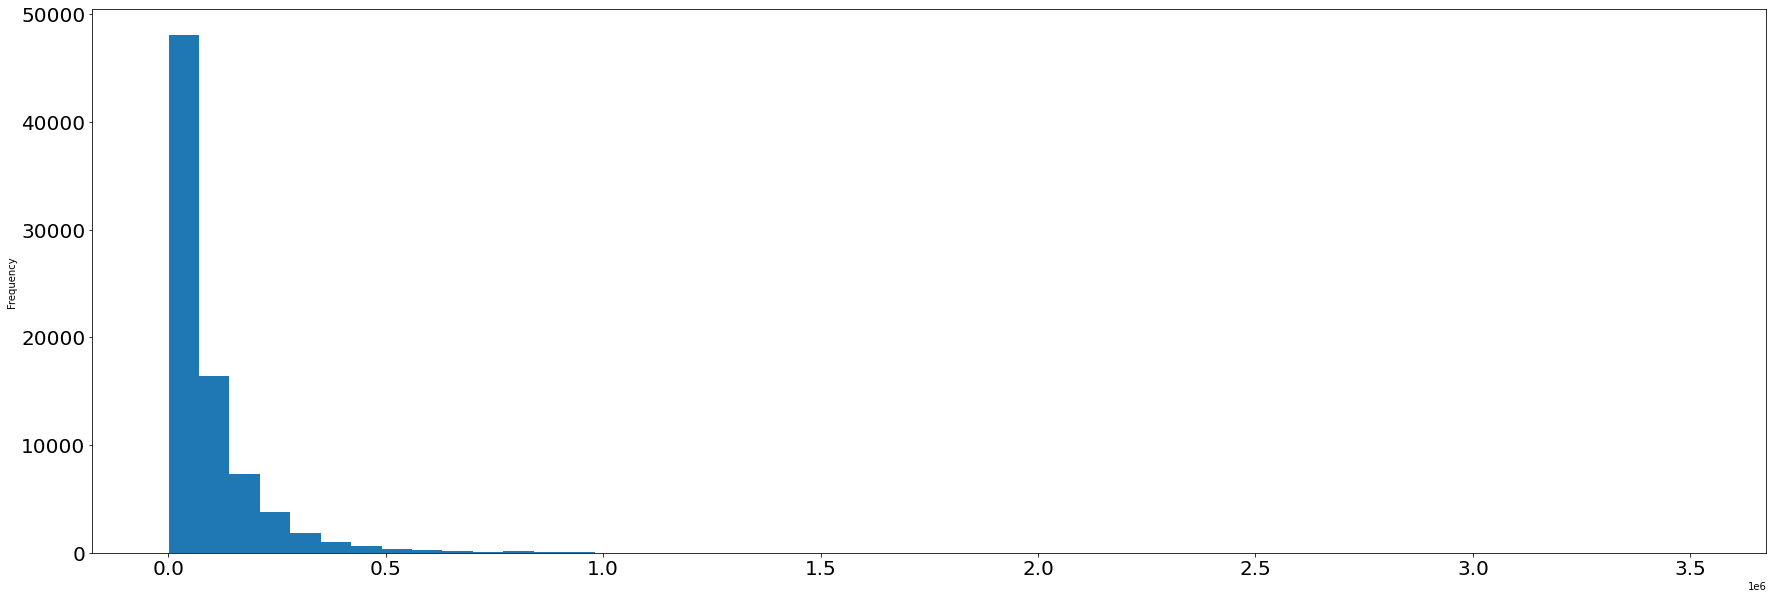

In [14]:
df['price'].plot(kind='hist', bins=50, fontsize=20)
plt.show()

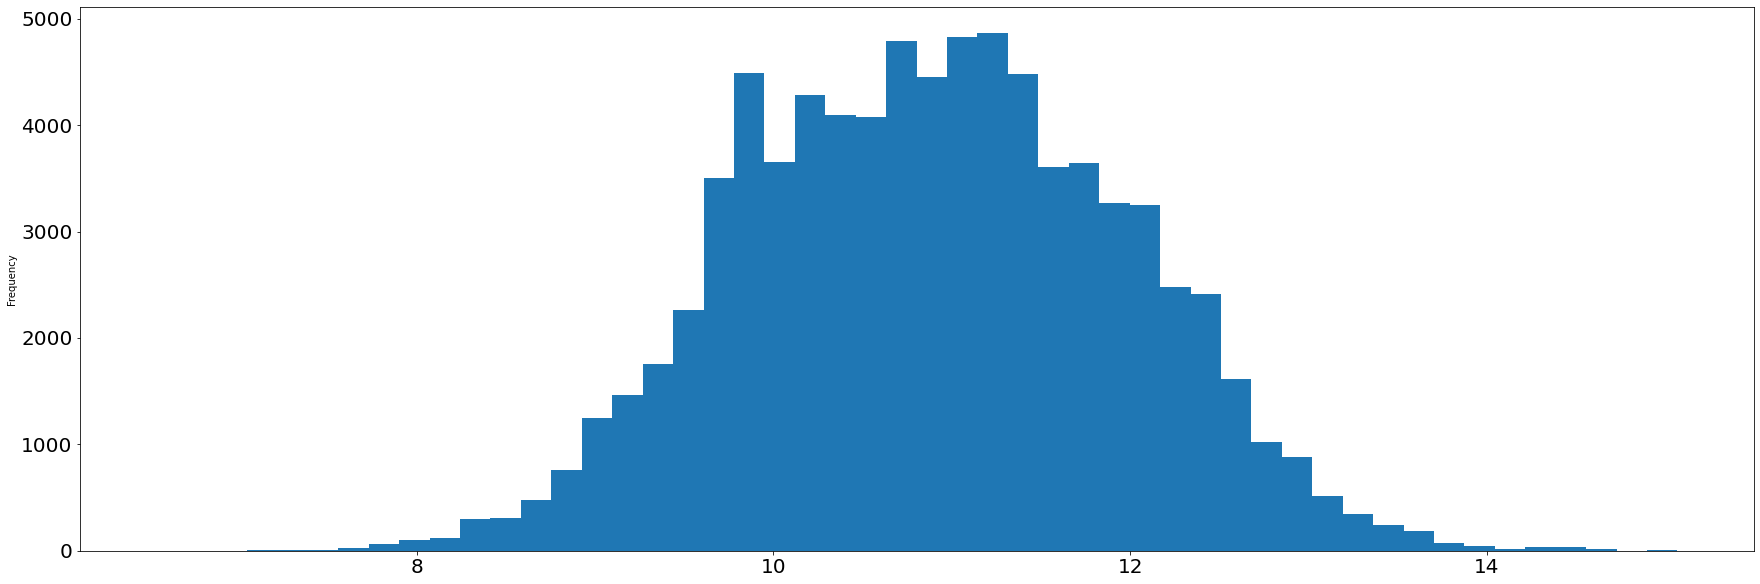

In [15]:
df['price'].apply(np.log).plot(kind='hist', bins=50, fontsize=20)
plt.show()

In [16]:
for price_data in [df['price'], df['price'].apply(np.log)]:
    name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
    test = sms.jarque_bera(price_data)
    print('Jarque-Bera')
    print(lzip(name, test))

Jarque-Bera
[('Jarque-Bera', 28226627.677027296), ('Chi^2 two-tail prob.', 0.0), ('Skew', 6.455786773540375), ('Kurtosis', 94.01565960677979)]
Jarque-Bera
[('Jarque-Bera', 353.9360954524362), ('Chi^2 two-tail prob.', 1.3923659664955492e-77), ('Skew', 0.04233299662355333), ('Kurtosis', 2.685684949425323)]


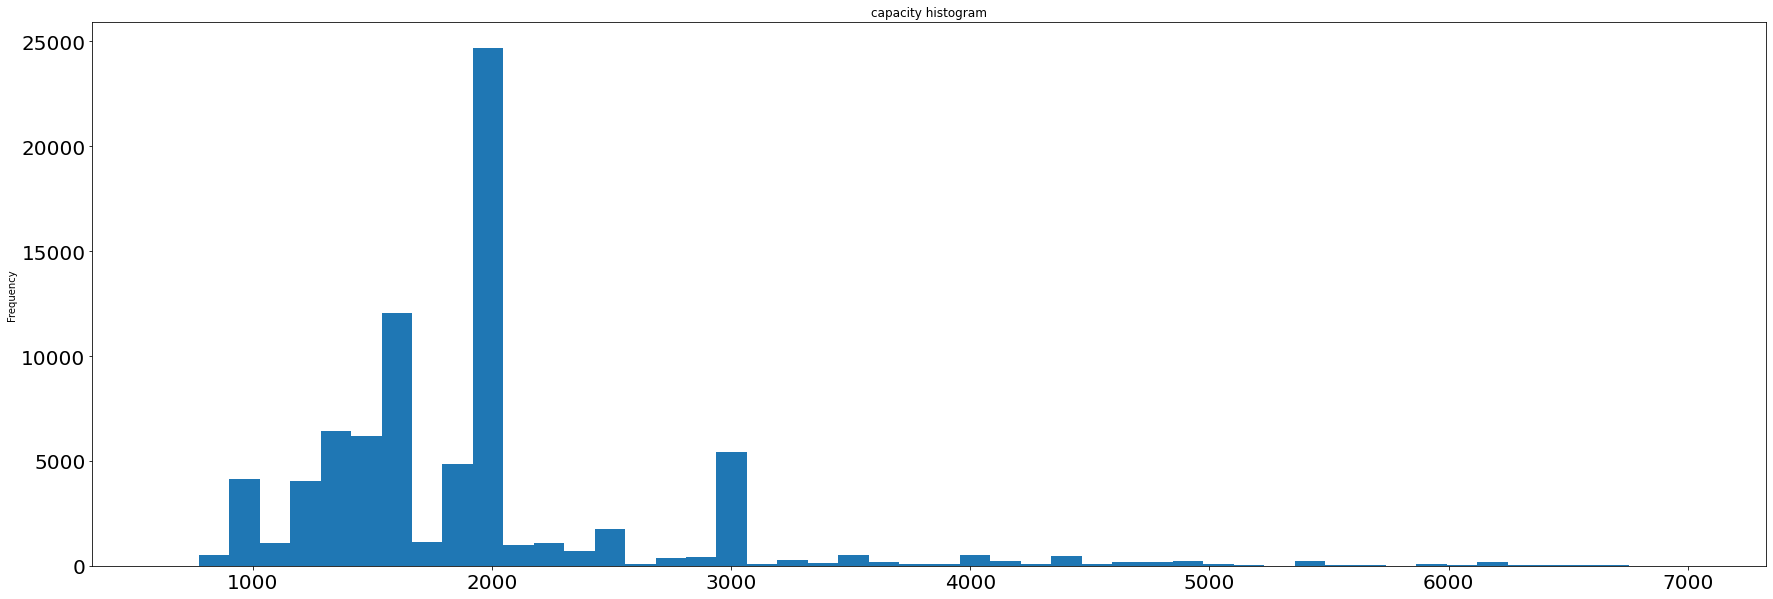

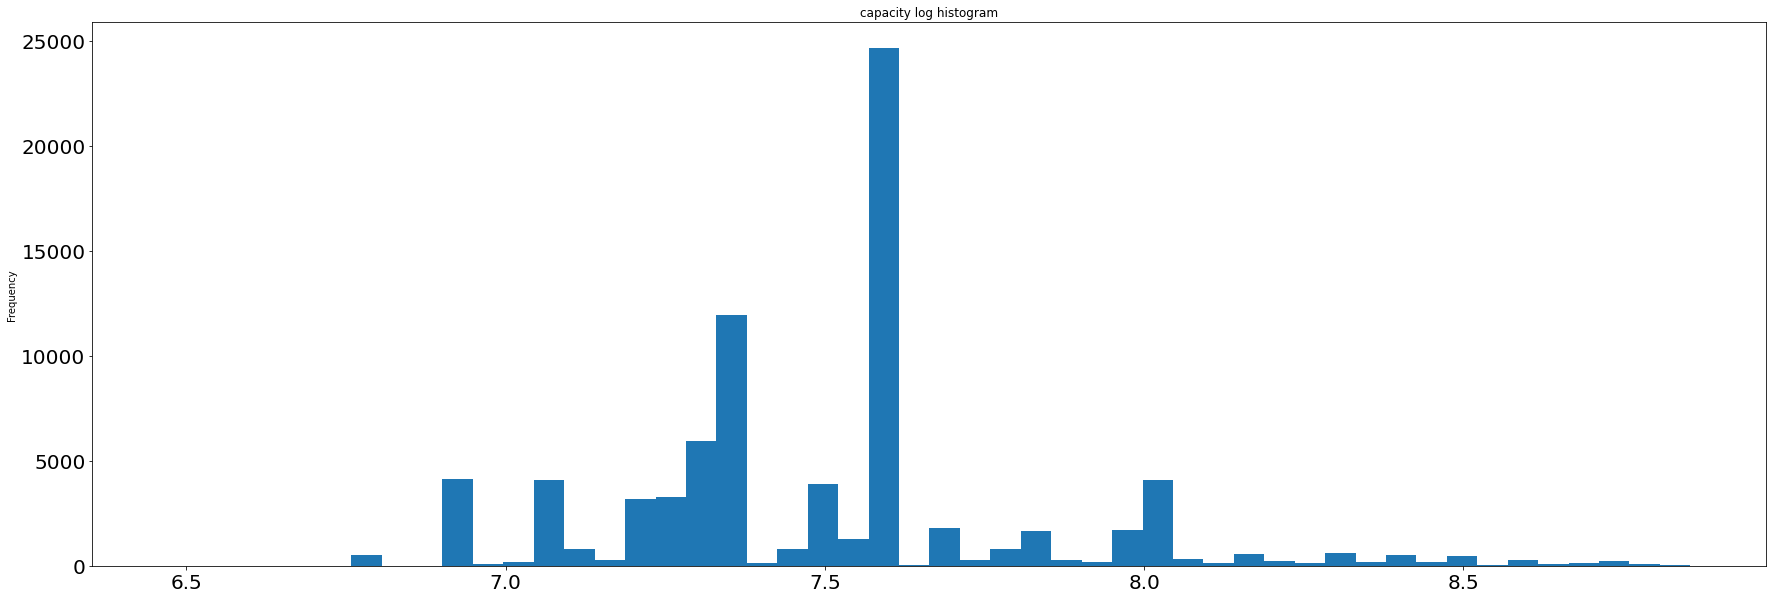

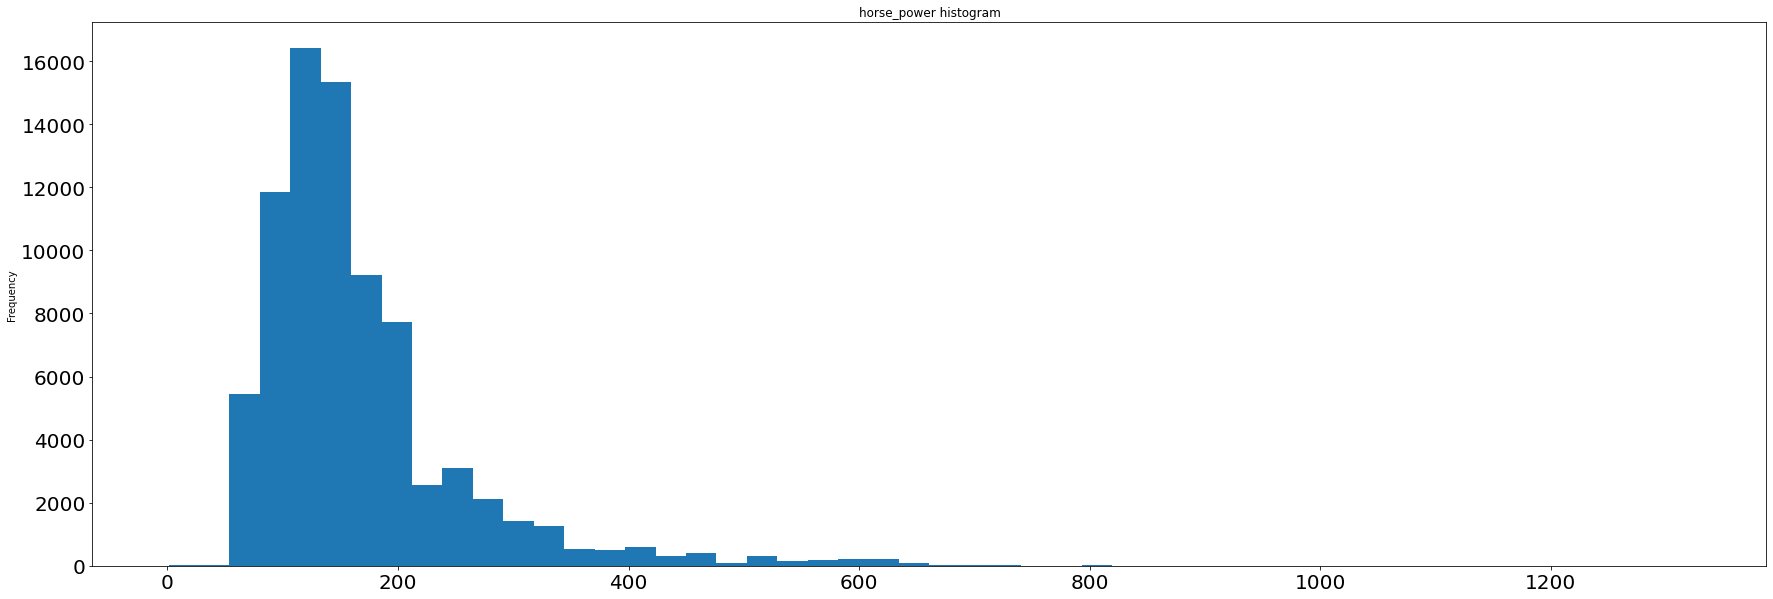

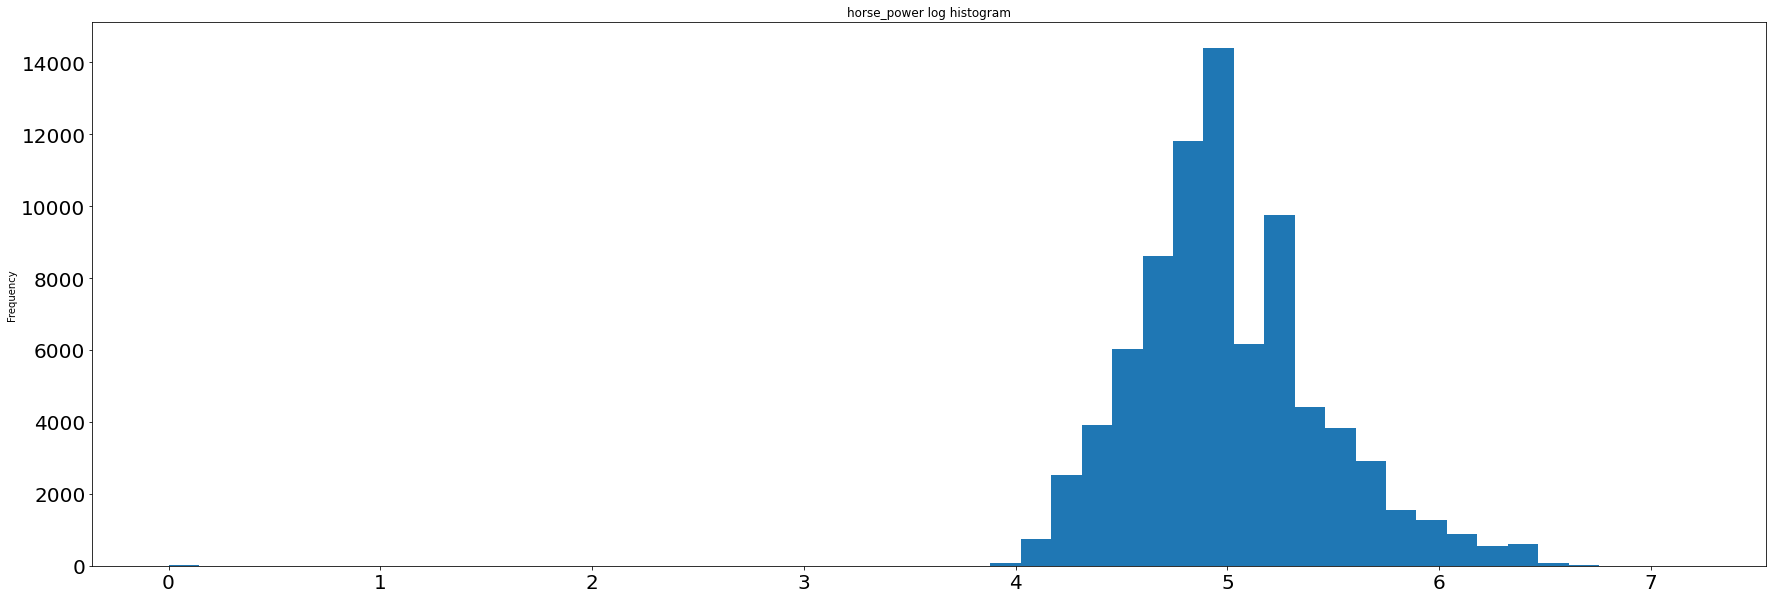

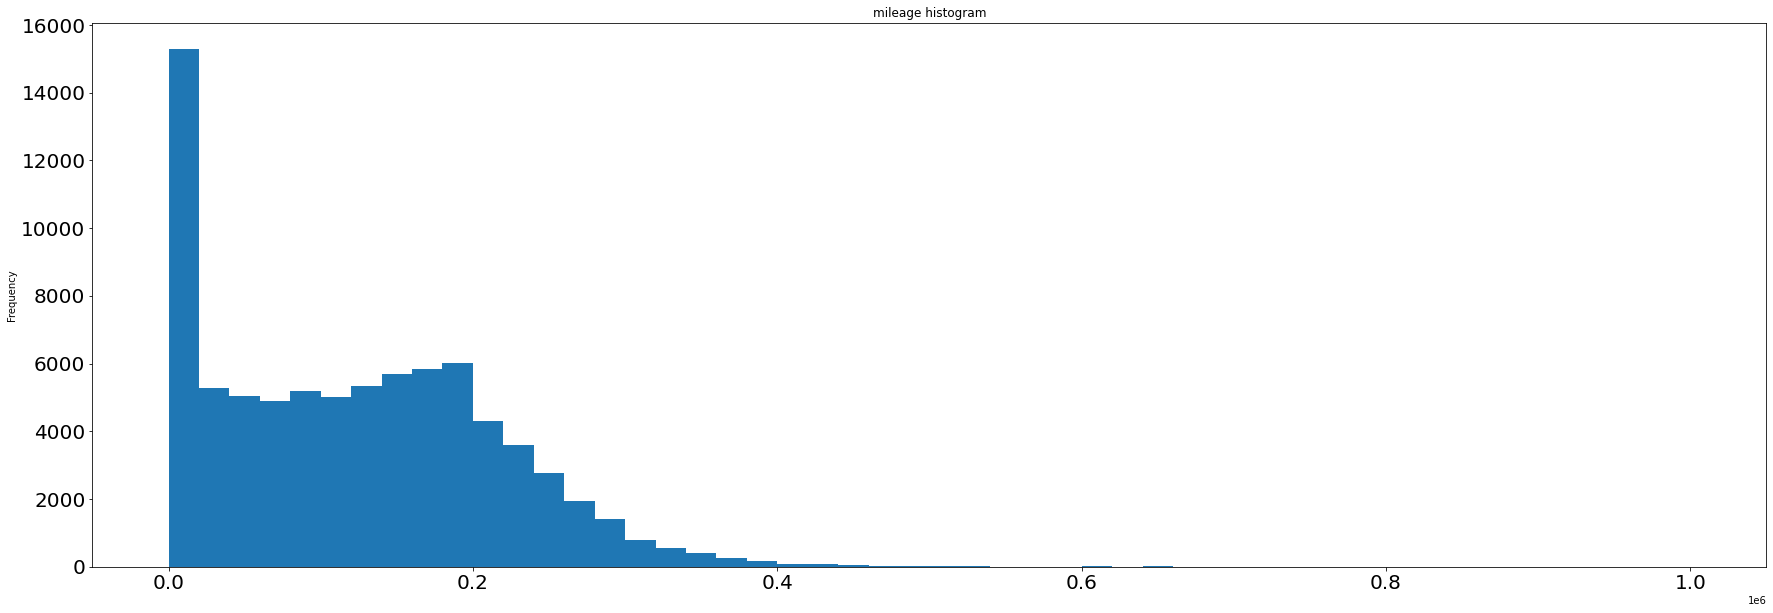

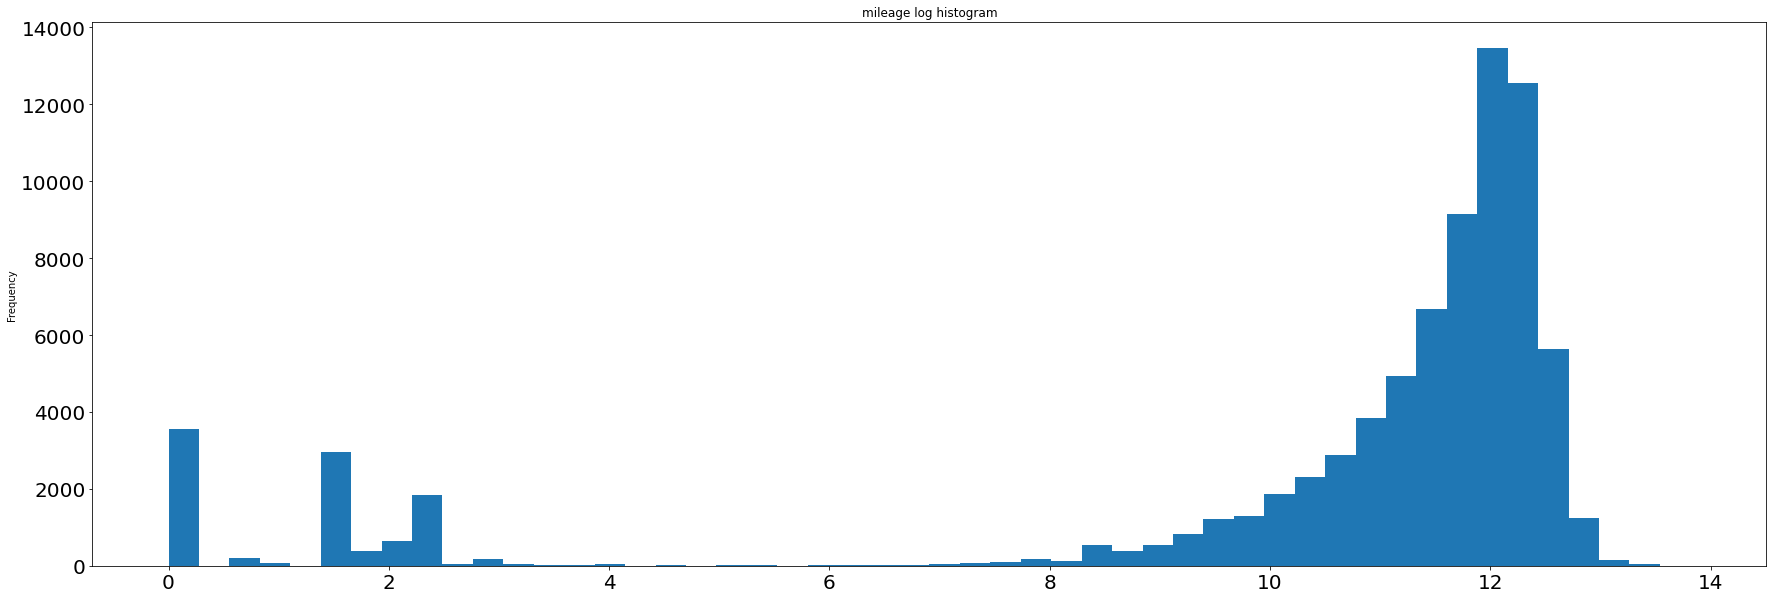

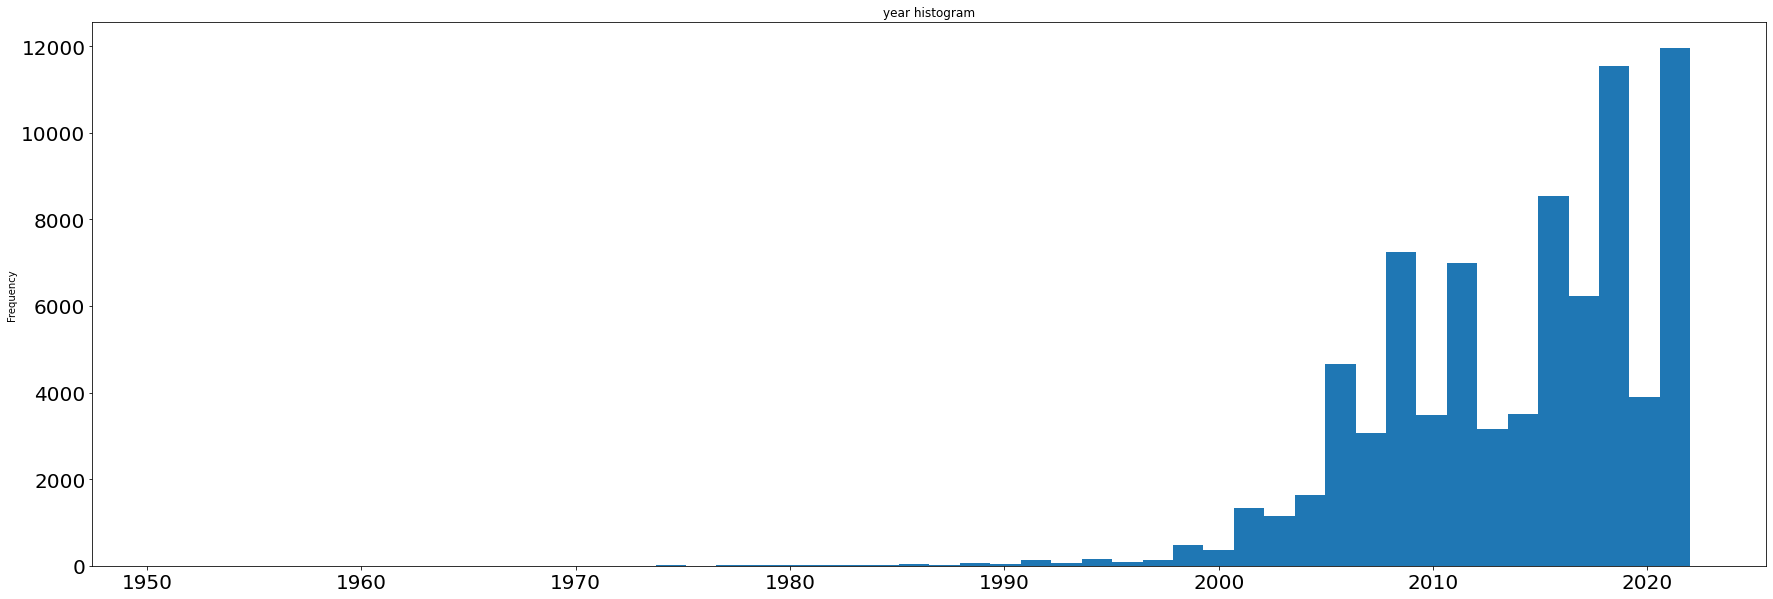

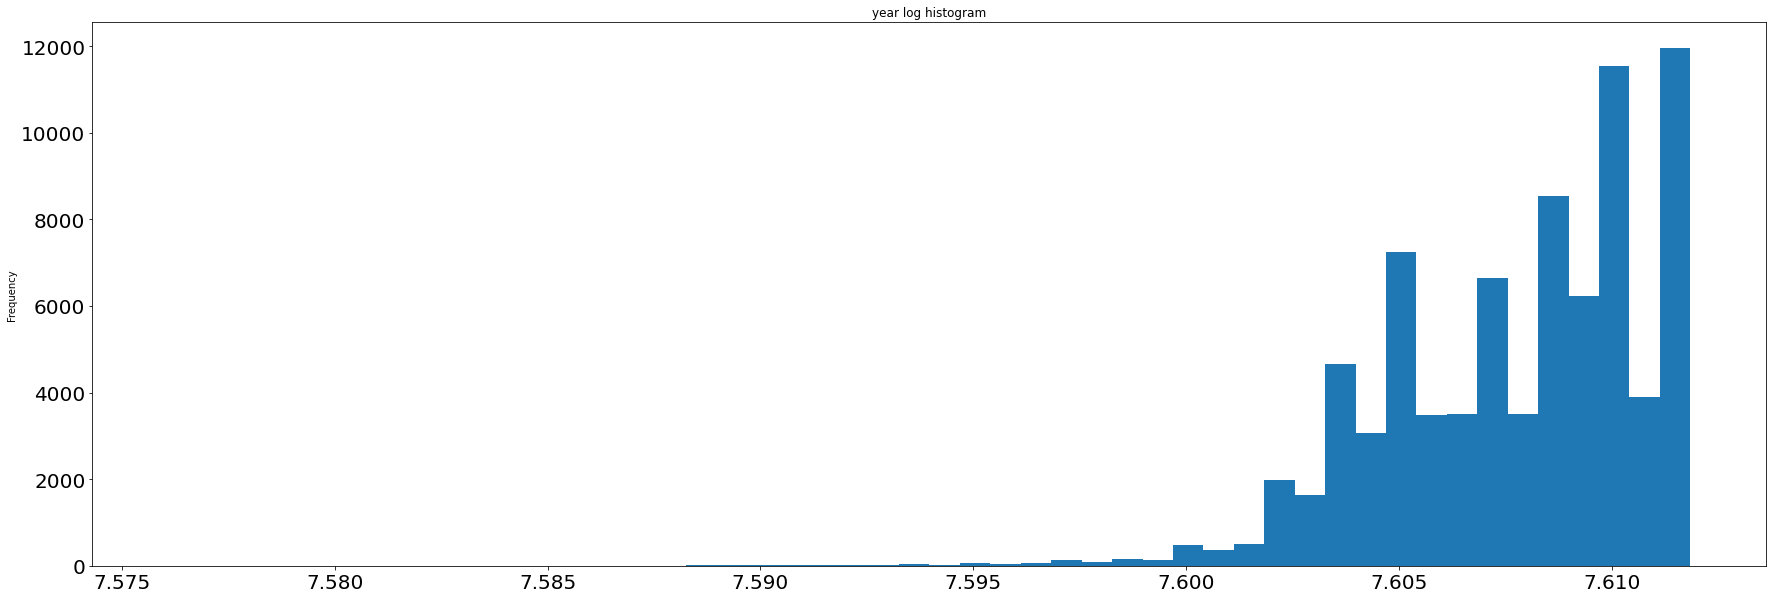

In [27]:
cols_to_hist = ['capacity', 'horse_power', 'mileage', 'year'] 
for col in cols_to_hist: 
    df[col].plot(kind='hist', bins=50, fontsize=20, title=f'{col} histogram')
    plt.show()
    df[col].apply(np.log).plot(kind='hist', bins=50, fontsize=20, title=f'{col} log histogram')
    plt.show()

In [28]:
cols_to_hist = ['capacity', 'horse_power', 'mileage', 'year'] 
for col in cols_to_hist: 
    for final_df, col_name in zip([df[col], df[col].apply(np.log)], [col, f'{col}log']):
        name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
        test = sms.jarque_bera(price_data)
        print('Jarque-Bera', col_name)
        print(lzip(name, test))

Jarque-Bera capacity
[('Jarque-Bera', 353.9360954524362), ('Chi^2 two-tail prob.', 1.3923659664955492e-77), ('Skew', 0.04233299662355333), ('Kurtosis', 2.685684949425323)]
Jarque-Bera capacitylog
[('Jarque-Bera', 353.9360954524362), ('Chi^2 two-tail prob.', 1.3923659664955492e-77), ('Skew', 0.04233299662355333), ('Kurtosis', 2.685684949425323)]
Jarque-Bera horse_power
[('Jarque-Bera', 353.9360954524362), ('Chi^2 two-tail prob.', 1.3923659664955492e-77), ('Skew', 0.04233299662355333), ('Kurtosis', 2.685684949425323)]
Jarque-Bera horse_powerlog
[('Jarque-Bera', 353.9360954524362), ('Chi^2 two-tail prob.', 1.3923659664955492e-77), ('Skew', 0.04233299662355333), ('Kurtosis', 2.685684949425323)]
Jarque-Bera mileage
[('Jarque-Bera', 353.9360954524362), ('Chi^2 two-tail prob.', 1.3923659664955492e-77), ('Skew', 0.04233299662355333), ('Kurtosis', 2.685684949425323)]
Jarque-Bera mileagelog
[('Jarque-Bera', 353.9360954524362), ('Chi^2 two-tail prob.', 1.3923659664955492e-77), ('Skew', 0.04233299

In [29]:
df.loc[:, cars[1:]].describe().T

,count,mean,std,min,25%,50%,75%,max
Audi,80165.0,0.103100,0.304091,0.0,0.0,0.0,0.0,1.0
BMW,80165.0,0.102613,0.303455,0.0,0.0,0.0,0.0,1.0
Bentley,80165.0,0.000936,0.030573,0.0,0.0,0.0,0.0,1.0
Chevrolet,80165.0,0.015892,0.125059,0.0,0.0,0.0,0.0,1.0
Citroën,80165.0,0.062958,0.242888,0.0,0.0,0.0,0.0,1.0
Dacia,80165.0,0.008994,0.094410,0.0,0.0,0.0,0.0,1.0
Ferrari,80165.0,0.001397,0.037352,0.0,0.0,0.0,0.0,1.0
Fiat,80165.0,0.003144,0.055979,0.0,0.0,0.0,0.0,1.0
Kia,80165.0,0.064005,0.244764,0.0,0.0,0.0,0.0,1.0
Lamborghini,80165.0,0.000574,0.023948,0.0,0.0,0.0,0.0,1.0


In [30]:
Y = df['price']
X = df.loc[:, df.columns != 'price']
X = sm.add_constant(X)
lm = sm.OLS(Y, X).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     5886.
Date:                Tue, 25 Jan 2022   Prob (F-statistic):               0.00
Time:                        22:51:38   Log-Likelihood:            -1.0034e+06
No. Observations:               80165   AIC:                         2.007e+06
Df Residuals:                   80124   BIC:                         2.007e+06
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -3.97e+06   1.41e+05    -

In [31]:
# X2 = df.drop(columns=lb.classes_).drop(columns='price')
# Y = df['price']
# lm2 = sm.OLS(Y, X2).fit()
# print(lm2.summary())

In [32]:
def get_model(Y, X): 
    lm =  sm.OLS(Y, X).fit()
    print(lm.summary())
    return lm

In [33]:
def print_all_tests(lm):
    name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
    test = sms.het_breuschpagan(lm.resid, lm.model.exog)
    print('breuschpagan')
    print(lzip(name, test))

    name = ["F statistic", "p-value"]
    test = sms.het_goldfeldquandt(lm.resid, lm.model.exog)
    print('goldfeldquandt')
    print(lzip(name, test))

    name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
    test = sms.jarque_bera(lm.resid)
    print('Jarque-Bera')
    # duza proba wiec olewamy 
    # jezeli mala proba i nie przechdozi to nie mozemy uzywac p-value 
    print(lzip(name, test))

    print(np.linalg.cond(lm.model.exog))

    print(sms.linear_reset(lm))
    # nie wierzymy w oszacowania parametrow 
    
    # jak mamy autokorelacja to nie wierzymy w std err i p value 
    # tak samo jak jest heteroskedastycznosc 



    # labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
    # white_test = sms.het_white(lm.resid,  lm.model.exog)
    # print(dict(zip(labels, white_test)))



In [34]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(lm.resid, lm.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 19139.357516741802),
 ('p-value', 0.0),
 ('f-value', 628.228486939784),
 ('f p-value', 0.0)]

In [35]:
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(lm.resid, lm.model.exog)
lzip(name, test)

[('F statistic', 0.9198685405565407), ('p-value', 0.9999999999999999)]

In [36]:
name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
test = sms.jarque_bera(lm.resid)
lzip(name, test)

[('Jarque-Bera', 77643218.63158955),
 ('Chi^2 two-tail prob.', 0.0),
 ('Skew', 4.652571647749512),
 ('Kurtosis', 155.17896384962762)]

In [37]:
np.linalg.cond(lm.model.exog)

93354762.56098351

In [38]:
print(sms.linear_reset(lm))

/home/kuba1302/.local/lib/python3.9/site-packages/statsmodels/stats/diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


<Wald test (chi2): statistic=86194.16218891572, p-value=0.0, df_denom=2>


In [39]:
print_all_tests(lm)

breuschpagan
[('Lagrange multiplier statistic', 19139.357516741802), ('p-value', 0.0), ('f-value', 628.228486939784), ('f p-value', 0.0)]
goldfeldquandt
[('F statistic', 0.9198685405565407), ('p-value', 0.9999999999999999)]
Jarque-Bera
[('Jarque-Bera', 77643218.63158955), ('Chi^2 two-tail prob.', 0.0), ('Skew', 4.652571647749512), ('Kurtosis', 155.17896384962762)]
93354762.56098351
<Wald test (chi2): statistic=86194.16218891572, p-value=0.0, df_denom=2>


In [57]:
# fig = sm.graphics.influence_plot(lm)
# fig.tight_layout(pad=1.0)

In [40]:
lm3 = get_model(Y=df['price'].apply(np.log), X=X.drop(columns=cars[1:]))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                 3.852e+04
Date:                Tue, 25 Jan 2022   Prob (F-statistic):               0.00
Time:                        22:51:42   Log-Likelihood:                -39779.
No. Observations:               80165   AIC:                         7.959e+04
Df Residuals:                   80151   BIC:                         7.972e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -139.5389      0.829   -1

In [41]:
print_all_tests(lm3)

breuschpagan
[('Lagrange multiplier statistic', 13477.7392369479), ('p-value', 0.0), ('f-value', 1246.0623204492995), ('f p-value', 0.0)]
goldfeldquandt
[('F statistic', 0.7872008896660128), ('p-value', 0.9999999999999999)]
Jarque-Bera
[('Jarque-Bera', 738505.2764246428), ('Chi^2 two-tail prob.', 0.0), ('Skew', 0.7604603840970976), ('Kurtosis', 17.791293835372272)]
91152874.79738331
<Wald test (chi2): statistic=7299.450920879623, p-value=0.0, df_denom=2>


/home/kuba1302/.local/lib/python3.9/site-packages/statsmodels/stats/diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


In [42]:
lm4 = get_model(Y=df['price'].apply(np.log), X=X.assign(mileage=lambda x: x['mileage'].apply(np.log)))
print_all_tests(lm4)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                 1.303e+04
Date:                Tue, 25 Jan 2022   Prob (F-statistic):               0.00
Time:                        22:51:43   Log-Likelihood:                -38377.
No. Observations:               80165   AIC:                         7.684e+04
Df Residuals:                   80124   BIC:                         7.722e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -176.6092      0.761   -2

/home/kuba1302/.local/lib/python3.9/site-packages/statsmodels/stats/diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


<Wald test (chi2): statistic=10604.907795683777, p-value=0.0, df_denom=2>


In [43]:
X3 = X.assign(mileage=lambda x: x['mileage'].apply(np.log), year=lambda x: x['year'].apply(np.log))
lm4 = get_model(Y=df['price'].apply(np.log), X=X3.dropna())
print_all_tests(lm4)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                 1.298e+04
Date:                Tue, 25 Jan 2022   Prob (F-statistic):               0.00
Time:                        22:51:45   Log-Likelihood:                -38513.
No. Observations:               80165   AIC:                         7.711e+04
Df Residuals:                   80124   BIC:                         7.749e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1407.5896      5.749   -2

/home/kuba1302/.local/lib/python3.9/site-packages/statsmodels/stats/diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


<Wald test (chi2): statistic=10778.507030519757, p-value=0.0, df_denom=2>


In [44]:
lm4 = get_model(Y=df['price'].apply(np.log), X=X)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                 1.462e+04
Date:                Tue, 25 Jan 2022   Prob (F-statistic):               0.00
Time:                        22:51:47   Log-Likelihood:                -34355.
No. Observations:               80165   AIC:                         6.879e+04
Df Residuals:                   80124   BIC:                         6.917e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -146.1070      0.794   -1

In [45]:
print_all_tests(lm4)

breuschpagan
[('Lagrange multiplier statistic', 14268.440886802904), ('p-value', 0.0), ('f-value', 433.7269551701214), ('f p-value', 0.0)]
goldfeldquandt
[('F statistic', 0.7774221273073458), ('p-value', 0.9999999999999999)]
Jarque-Bera
[('Jarque-Bera', 1082018.936378274), ('Chi^2 two-tail prob.', 0.0), ('Skew', 0.9013154736994587), ('Kurtosis', 20.90776595123154)]
93354762.56098351


/home/kuba1302/.local/lib/python3.9/site-packages/statsmodels/stats/diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


<Wald test (chi2): statistic=5885.175236731437, p-value=0.0, df_denom=2>


In [46]:
X_final = X.assign(
    aso_mileage = lambda x: x['aso'] * x['mileage'], 
    horse_power_2 = lambda x: x['horse_power'] ** 2 
).drop(columns=['number_of_doors', 'capacity'])

In [47]:
X_final.isna().sum()

const            0
aso              0
new              0
first_owner      0
horse_power      0
mileage          0
no_accidents     0
automatyczna     0
year             0
Audi             0
BMW              0
Bentley          0
Chevrolet        0
Citroën          0
Dacia            0
Ferrari          0
Fiat             0
Kia              0
Lamborghini      0
Land Rover       0
Lexus            0
MINI             0
Maserati         0
Mazda            0
McLaren          0
Mercedes-Benz    0
Mitsubishi       0
Porsche          0
Renault          0
Rolls-Royce      0
Saab             0
Seat             0
Suzuki           0
Toyota           0
Volvo            0
Škoda            0
Benzyna+LPG      0
Diesel           0
Hybryda          0
aso_mileage      0
horse_power_2    0
dtype: int64

In [48]:
formula = 'price ~ aso + capacity + capacity + first_owner + horse_power + mileage + no_accidents + number_of_doors + automatyczna + year'
res = smf.ols(formula=formula, data=df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                 1.482e+04
Date:                Tue, 25 Jan 2022   Prob (F-statistic):               0.00
Time:                        22:51:48   Log-Likelihood:            -1.0191e+06
No. Observations:               80165   AIC:                         2.038e+06
Df Residuals:                   80155   BIC:                         2.038e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -7.582e+06   1.54e+05    -

In [49]:
print_all_tests(res)

breuschpagan
[('Lagrange multiplier statistic', 4562.8507836966055), ('p-value', 0.0), ('f-value', 537.514561216456), ('f p-value', 0.0)]
goldfeldquandt
[('F statistic', 0.8087482649325257), ('p-value', 0.9999999999999999)]
Jarque-Bera
[('Jarque-Bera', 205461198.06123218), ('Chi^2 two-tail prob.', 0.0), ('Skew', 9.566381975283852), ('Kurtosis', 250.27601846883826)]
83681032.62272967
<Wald test (chi2): statistic=25460.972858005443, p-value=0.0, df_denom=2>


/home/kuba1302/.local/lib/python3.9/site-packages/statsmodels/stats/diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


In [50]:
lm4 = get_model(Y=df['price'].apply(np.log), X=X_final.dropna())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                 1.528e+04
Date:                Tue, 25 Jan 2022   Prob (F-statistic):               0.00
Time:                        22:51:48   Log-Likelihood:                -32779.
No. Observations:               80165   AIC:                         6.564e+04
Df Residuals:                   80124   BIC:                         6.602e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -132.5664      0.710   -186.801

In [51]:
print_all_tests(lm4)

breuschpagan
[('Lagrange multiplier statistic', 14325.914939403534), ('p-value', 0.0), ('f-value', 435.85417672053006), ('f p-value', 0.0)]
goldfeldquandt
[('F statistic', 0.7633694356876247), ('p-value', 0.9999999999999999)]
Jarque-Bera
[('Jarque-Bera', 1133256.7904069463), ('Chi^2 two-tail prob.', 0.0), ('Skew', 0.9985724470048702), ('Kurtosis', 21.310889929467727)]
96298240.42385682


/home/kuba1302/.local/lib/python3.9/site-packages/statsmodels/stats/diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


<Wald test (chi2): statistic=4529.250979638654, p-value=0.0, df_denom=2>


In [52]:
gamma_model_1 = sm.GLM(Y, X_final, family=sm.families.Gamma()).fit()

/home/kuba1302/.local/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [53]:
print(gamma_model_1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  price   No. Observations:                80165
Model:                            GLM   Df Residuals:                    80124
Model Family:                   Gamma   Df Model:                           40
Link Function:          inverse_power   Scale:                         0.40519
Method:                          IRLS   Log-Likelihood:            -1.0458e+06
Date:                Tue, 25 Jan 2022   Deviance:                   1.0582e+05
Time:                        22:51:54   Pearson chi2:                 3.25e+04
No. Iterations:                    26   Pseudo R-squ. (CS):            -0.6766
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0009   4.54e-06    202.495